In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm

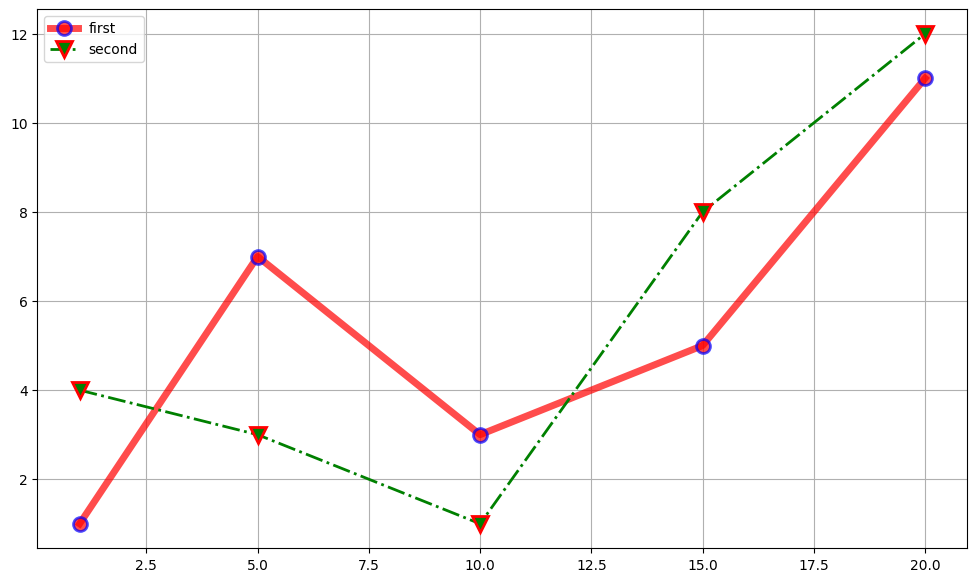

In [2]:
x = [1, 5, 10, 15, 20]
y1 = [1, 7, 3, 5, 11]
y2 = [4, 3, 1, 8, 12]
plt.figure(figsize=(12, 7))
plt.plot(x, y1, 'o-r', alpha=0.7, label="first", lw=5, mec='b', mew=2, ms=10)
plt.plot(x, y2, 'v-.g', label="second", mec='r', lw=2, mew=2, ms=12)
plt.legend()
plt.grid(True)

In [3]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import pandas as pd
import torch
from torch import nn
from torchvision.io import read_image
from torchvision.models import MobileNet_V2_Weights, mobilenet_v2
import numpy as np
from collections import defaultdict
from functools import partial
from itertools import chain
import sqlite3
import os
import typing
from typing import Optional
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from collections import defaultdict
from accelerate import Accelerator

C:\Users\sofi\AppData\Roaming\Python\Python39\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
C:\Users\sofi\AppData\Roaming\Python\Python39\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [4]:
# фиксации параметров в рамках всего запуска
def seed_everything(seed: int) -> None:
    import os
    import random
    import torch
    import numpy as np

    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

SEED = 13
seed_everything(SEED)

import torch
g = torch.Generator()
g.manual_seed(0)

# accelerator = Accelerator(mixed_precision="no", cpu=True)
accelerator = Accelerator(mixed_precision="no")

device = accelerator.device
print(device)

cuda


In [5]:
def visualise_pics(dataset, indexes):
    items = [dataset[index] for index in indexes]
    figure, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
    for i, (image, _) in enumerate(items):
        ax.ravel()[i].imshow(image.numpy().transpose([1, 2, 0]))
        ax.ravel()[i].set_axis_off()
    plt.show()

def visualise_1pic(img: torch.Tensor) -> None:
    plt.imshow(torch.einsum("chw->hwc", img))
    plt.plot()

In [6]:
def get_target(data_dir: Path,
               le: typing.Optional[LabelEncoder] = None,
               label_encoder_pickle_file: Path = Path.cwd() / "data" / "labelencoder.pkl",
               feedbacks : bool = True,
               ):

    categories = os.listdir(data_dir)
    if feedbacks:
        paths_card = [data_dir / category / "card" for category in categories]
        paths_feedbacks = [data_dir / category / "feedbacks" for category in categories]
        img_paths = [sorted(sub_category.rglob("*.png")) for sub_category in paths_card + paths_feedbacks]
        img_paths = list(chain(*img_paths))
    else:
        paths_card = [data_dir / category / "card" for category in categories]
        img_paths = [sorted(sub_category.rglob("*.png")) for sub_category in paths_card]
        img_paths = list(chain(*img_paths))
    
    target = [path.parts[-3:-2][0] for path in img_paths]
    
    if not le:
        le = LabelEncoder()
        le = le.fit(target)

        # пока убрали сохранение
#         label_encoder_pickle_file.unlink(missing_ok=True)

#         with open(label_encoder_pickle_file, 'wb') as handle:
#             pickle.dump(le, handle, protocol=pickle.HIGHEST_PROTOCOL)

    target_enc = le.transform(target)

    # Соотнесения закодированного таргета и названий категорий
    dict_topic = dict(zip(target, target_enc))
    target2idx = dict(sorted(dict_topic.items(), key=lambda item: item[1]))
    idx2target = dict(zip(target_enc, target))

    return img_paths, torch.from_numpy(target_enc).long(), target2idx, idx2target


def get_traintestsplit(img_paths : list[Path],
                       target_enc : list,
                       SEED : int,
                       ):
    
    train_paths, test_paths, ytrain, ytest = train_test_split(img_paths, target_enc,
                                                              test_size=0.1,
                                                              stratify=target_enc,
                                                              random_state=SEED)
    return train_paths, test_paths, ytrain, ytest

In [7]:
class WbDataset(Dataset):
    def __init__(self,
                 img_paths,
                 target=None,
                 transform=None):

        self.img_paths = img_paths
        self.target = target
        self.transform = transform
        
    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img =  read_image(str(img_path))
        
        if self.transform is not None:
            img = self.transform(img)
        if self.target is not None:
            label = self.target[index]
            return img, label

        return img


    def __len__(self):
        return len(self.img_paths)

In [8]:
data_dir = Path("E:/!sofi/Datasets/datasets/hse-mlds-project-year2") / "woman/woman"
processor = MobileNet_V2_Weights.IMAGENET1K_V2.transforms(
    antialias=True,
)

img_paths, target_enc, _, idx2target = get_target(data_dir)
train_paths, test_paths, ytrain, ytest = get_traintestsplit(img_paths, target_enc, SEED)

train_dataset = WbDataset(train_paths, ytrain, processor)
test_dataset = WbDataset(test_paths, ytest, processor)

In [9]:
image = train_dataset[0]

# чекаем что размеры консистентны
image[0].shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


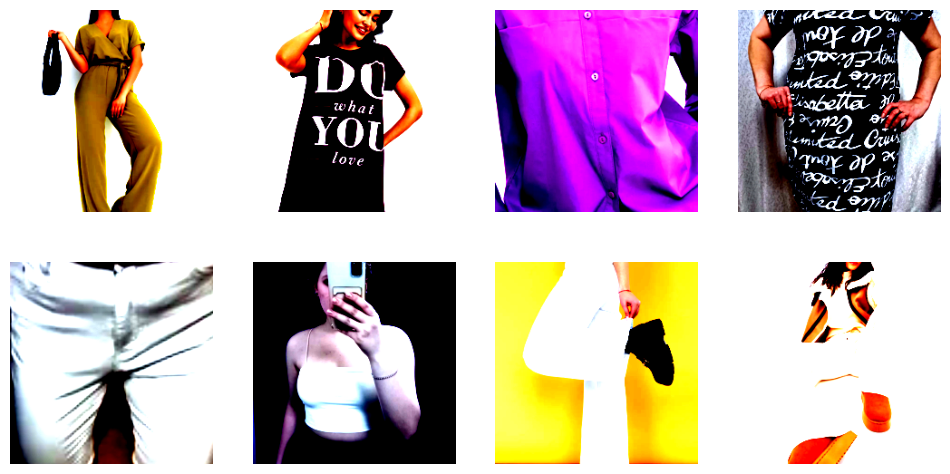

In [10]:
length = len(train_dataset)
indexes = np.random.choice(list(range(length)), size=8, replace=False)

visualise_pics(train_dataset, indexes)

In [11]:
class Collator:
    def __init__(self, transform=None, mixes=None) -> None:
        self.transform = transform
        self.mixes = mixes

    def __call__(self, batch):
        data, targets = zip(*batch)
        data = torch.stack(data)
        targets = torch.tensor(targets)

        if self.mixes is not None:
            data, target = self.mixes(data, targets)
        if self.transform is not None:
            data = self.transform(data)
        return data, targets

In [12]:
#dataset = torch.utils.data.Subset(dataset, [i for i in range(100)])
BATCH_SIZE = 16

train_loader = accelerator.prepare_data_loader(DataLoader(train_dataset,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               collate_fn=Collator(),
                                               pin_memory=True,
                                               generator=torch.Generator().manual_seed(SEED),
                                               worker_init_fn=seed_worker)
                                                                  )


val_loader = accelerator.prepare_data_loader(DataLoader(test_dataset,
                                             batch_size=BATCH_SIZE,
                                             shuffle=False,
                                             collate_fn=Collator(),
                                             pin_memory=True,
                                             generator=torch.Generator().manual_seed(SEED),
                                             worker_init_fn=seed_worker)
                                                                )

In [13]:
# elem = next(iter(train_loader))
# elem[0].shape

# visualise_1pic(elem[0][0])

In [14]:
pretrain_model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V2)

In [15]:
#pretrain_model 

In [16]:
class Model(torch.nn.Module):
    def __init__(
        self,
        module_features,
        num_classes: int,
        module_out_size: int = 1280,
        dropout_prob: float = 0.3,
    ):
        super().__init__()
        self.module_features = module_features
        self.module_avgpool = torch.nn.AdaptiveAvgPool2d(output_size=1)
        self.out = torch.nn.Sequential(
            torch.nn.Dropout(p=dropout_prob),
            torch.nn.Linear(in_features=module_out_size, out_features=num_classes),
        )

    def forward(self, inputs):
        step_1 = self.module_features(inputs)
        step_2 = self.module_avgpool(step_1)
        logits = self.out(torch.flatten(step_2, 1))

        return logits

In [17]:
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_metrics, valid_metrics):
    clear_output()
    fig, axs = plt.subplots(3, 2, figsize=(26, 13))
    axs[0][0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0][0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0][0].set_ylabel('loss')

    for (ax1, ax2), train_m_name, valid_m_name in zip(((0, 1), (1, 0), (1, 1), (2, 0), (2, 1)), train_metrics, valid_metrics):
        train_m, valid_m = train_metrics[train_m_name], valid_metrics[valid_m_name]
        axs[ax1][ax2].plot(range(1, len(train_m) + 1), train_m, label='train')
        axs[ax1][ax2].plot(range(1, len(valid_m) + 1), valid_m, label='test')
        axs[ax1][ax2].set_ylabel(train_m_name)

    for ax1 in axs:
        for ax2 in ax1:
            ax2.set_xlabel('epoch')
            ax2.legend()

    plt.show()

In [20]:
class Trainer:
    def __init__(
        self,
        model,
        optimizer,
        scheduler,
        criterion,
        accelerator,
        device,
    ):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.criterion = criterion
        self.accelerator = accelerator
        self.device = device

    @staticmethod
    def training_epoch(
        self,
        train_loader: DataLoader,
        train_transform,
        train_mixes,
        epoch: int,
        tqdm_desc,
    ):
        num_batches = 0.0
        train_loss = 0.0
        metrics = defaultdict(float)
        self.model.train()
        
        for data, target in tqdm(train_loader, desc=tqdm_desc):
#             data = data.to(self.device)
#             target = target.to(self.device)
            target_mult = target
            if train_mixes is not None:
                data, target_mult = train_mixes(data, target)
            if train_transform is not None:
                data = train_transform(data)
                
            with self.accelerator.accumulate(self.model):
                logits = self.model(data)
                loss = self.criterion(logits, target_mult)
                self.accelerator.backward(loss)
                self.optimizer.step()
                self.optimizer.zero_grad()

            train_loss += loss.item()
            for m_name, m in {
                "accuracy": partial(accuracy_score),
                "precision": partial(precision_score, average="macro", zero_division=0),
                "recall": partial(recall_score, average="macro", zero_division=0),
                "f1 macro": partial(f1_score, average="macro"),
            }.items():
                metrics[m_name] += m(
                    target.detach().cpu().numpy(), np.argmax(logits.detach().cpu().numpy(), axis=-1)
                )

            num_batches += 1

        train_loss /= num_batches
        for m_name in metrics:
            metrics[m_name] /= num_batches
        return train_loss, metrics

    @staticmethod
    @torch.no_grad()
    def validation_epoch(
        self,
        val_loader: DataLoader,
        epoch: int,
        tqdm_desc,
    ):
        num_batches = 0.0
        val_loss = 0.0
        metrics = defaultdict(float)
        self.model.eval()
        for data, target in tqdm(val_loader, desc=tqdm_desc):
#             data = data.to(self.device)
#             target = target.to(self.device)
            logits = self.model(data)
            loss = self.criterion(logits, target)

            val_loss += loss.item()
            for m_name, m in {
                "accuracy": partial(accuracy_score),
                "precision": partial(precision_score, average="macro", zero_division=0),
                "recall": partial(recall_score, average="macro", zero_division=0),
                "f1 macro": partial(f1_score, average="macro"),
            }.items():
                metrics[m_name] += m(
                    target.detach().cpu().numpy(), np.argmax(logits.detach().cpu().numpy(), axis=-1)
                )

            num_batches += 1

        val_loss /= num_batches
        for m_name in metrics:
            metrics[m_name] /= num_batches
        return val_loss, metrics

    def train(
        self,
        train_loader: DataLoader,
        val_loader: DataLoader,
        num_epochs: int,
        plot: bool,
        train_transform=None,
        train_mixes=None,
        if_save: bool = False,
        save_path: Optional[Path] = None,
    ):
        train_losses = []
        val_losses = []
        train_metrics, val_metrics = defaultdict(list), defaultdict(list)

        for epoch in range(1, num_epochs + 1):
            train_loss, train_metric = self.training_epoch(
                self,
                train_loader,
                train_transform,
                train_mixes,
                epoch,
                tqdm_desc=f'Training {epoch}/{num_epochs}'
            )
            val_loss, val_metric = self.validation_epoch(
                self,
                val_loader,
                epoch,
                tqdm_desc=f'Validating {epoch}/{num_epochs}'
            )

            if self.scheduler is not None:
                self.scheduler.step()

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            for m_name, m_value in train_metric.items():
                train_metrics[m_name].append(m_value.item())
            for m_name, m_value in val_metric.items():
                val_metrics[m_name].append(m_value.item())

            if plot:
                plot_losses(train_losses, val_losses, train_metrics, val_metrics)

            print(f"Epoch {epoch}")
            print("val metrics")
            print(f"loss {val_losses[-1]}")
            for elem in val_metrics.items():
                print(elem[0], elem[1][-1])
            print("\ntrain metrics")
            print(f"loss {train_losses[-1]}")
            for elem in train_metrics.items():
                print(elem[0], elem[1][-1])
            print('-'*50)

            if save:
                accelerator.save_state(output_dir=save_path / f"checkpoint_afterepoch_{epoch}of{num_epochs}")

        return train_losses, val_losses, train_metrics, val_metrics

In [21]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device #= 'cpu'

In [22]:
NUM_CLASSES=len(idx2target)

In [23]:
# Учим только последний слой
for param in pretrain_model.parameters():
#        param.requires_grad = False
       param.requires_grad = True

model = Model(
    module_features=pretrain_model.features,
    num_classes=NUM_CLASSES,
)

sum(param.numel() for param in model.parameters())

2240525

In [24]:
NUM_EPOCHS = 15

# model = model.to(device)
optimizer = torch.optim.AdamW(
    [
#         {"params": model.module_features.parameters(), "lr": 3e-4, "weight_decay": 1e-5},
        {"params": model.module_avgpool.parameters(), "lr": 3e-4, "weight_decay": 1e-5},
        {"params": model.out.parameters(), "lr": 3e-4},
    ],
)
criterion = torch.nn.CrossEntropyLoss().to(device)
model, optimizer = accelerator.prepare(model, optimizer)

In [25]:
#accelerator.save_state(output_dir=f"mobilenet_v2")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


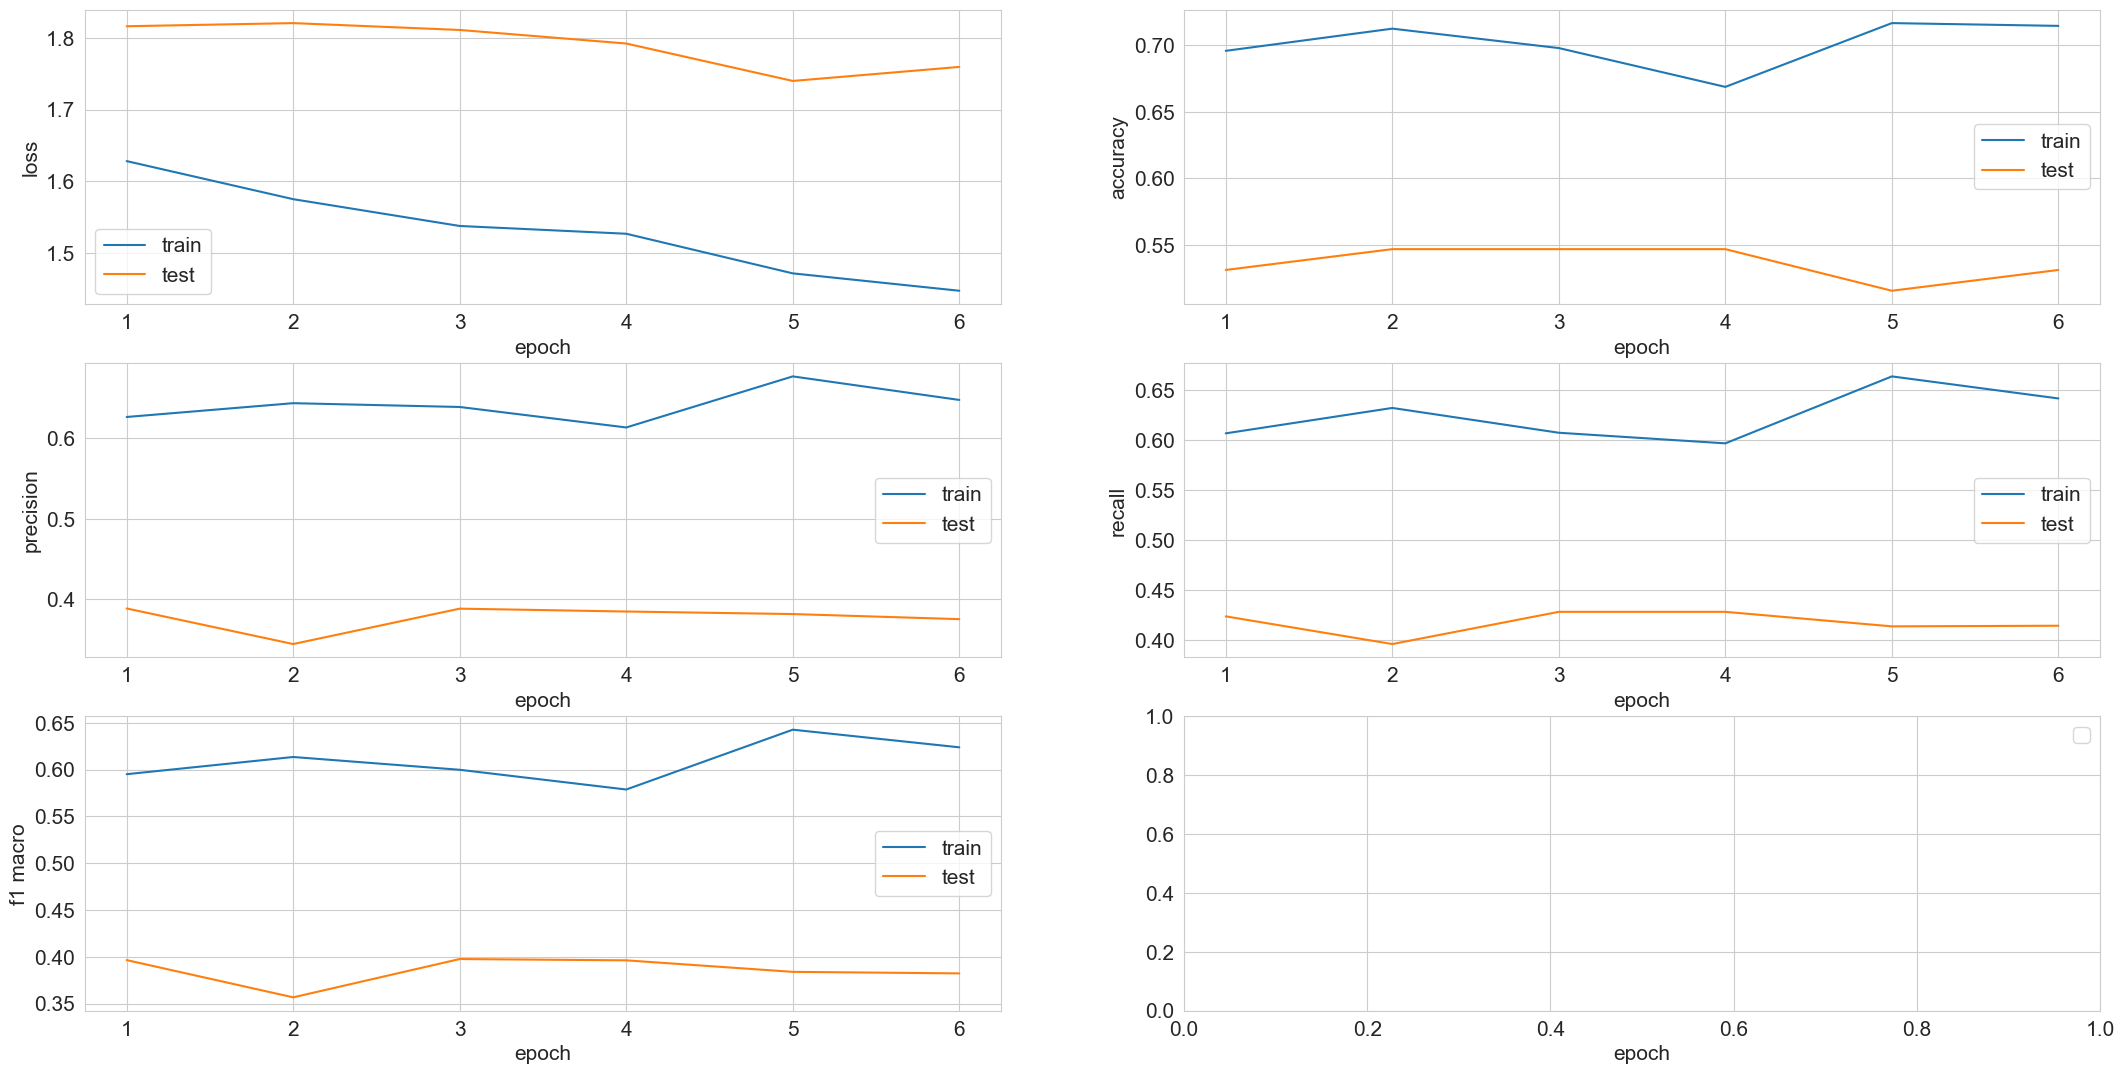

Epoch 6
val metrics
loss 1.759482890367508
accuracy 0.53125
precision 0.3753156565656566
recall 0.4141414141414141
f1 macro 0.38229617604617605

train metrics
loss 1.4469743053118387
accuracy 0.7145833333333333
precision 0.6478532547699215
recall 0.6413441250107916
f1 macro 0.6239289260122595
--------------------------------------------------


Training 7/15:   0%|          | 0/30 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [29]:
trainer = Trainer(
            model,
            optimizer,
            None,
            criterion,
            accelerator,
            device,
        )
train_losses, test_losses, train_metrics, test_metrics = trainer.train(
            train_loader, val_loader, NUM_EPOCHS, True)

In [27]:
@torch.no_grad()
def inference(model, loader, device):
    model.eval()
    y_preds = []
    for data in tqdm(loader):
        data = data.to(device)
        logits = model(data)
        y_pred = np.argmax(logits.detach().cpu().numpy(), axis=-1)

        y_preds.extend(y_pred)
    return y_preds

In [28]:
dataset_test = WbDataset(test_paths, None, processor)

test_loader = accelerator.prepare_data_loader(DataLoader(dataset_test,
                                                         batch_size=BATCH_SIZE,
                                                         shuffle=False,
                                                         pin_memory=True,
                                                         generator=torch.Generator().manual_seed(SEED),
                                                         worker_init_fn=seed_worker)
                                             )

len(dataset_test)

52

In [29]:
y_preds = inference(model, test_loader, device)

  0%|          | 0/4 [00:00<?, ?it/s]

In [30]:
y_preds

[5,
 4,
 4,
 1,
 9,
 9,
 4,
 1,
 8,
 6,
 6,
 1,
 9,
 7,
 1,
 7,
 6,
 8,
 7,
 6,
 4,
 6,
 6,
 7,
 8,
 9,
 2,
 5,
 5,
 6,
 9,
 4,
 8,
 12,
 8,
 9,
 6,
 9,
 9,
 5,
 6,
 12,
 9,
 4,
 0,
 2,
 12,
 6,
 7,
 3,
 7,
 4]